# The Battle of Neighborhoods- Milan neighborhoods price houses

In [672]:
# Import python libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from arcgis.geocoding import geocode
from arcgis.gis import GIS
gis = GIS()
import folium
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import f1_score

## Data Collection

In [673]:
url = 'https://www.immobiliare.it/mercato-immobiliare/lombardia/milano/'
r = requests.get(url)
print(r.status_code)

200


In [674]:
soup = BeautifulSoup(r.text,'html.parser')
neighborhood_table = soup.find('table')
neighborhoods_prices = []
for data in neighborhood_table.find_all('tbody'):
    rows = data.find_all('tr')
    for row in rows:
        neighborhood = row.find('a',class_='nd-table__url').text
        avg_sale_price = row.find_all('td')[1].text
        data = {'neighborhood':neighborhood,
               'avg_sale_price':avg_sale_price}
        neighborhoods_prices.append(data)
neighborhoods_prices

[{'neighborhood': 'Centro', 'avg_sale_price': '9.366'},
 {'neighborhood': 'Arco della Pace, Arena, Pagano', 'avg_sale_price': '7.764'},
 {'neighborhood': 'Genova, Ticinese', 'avg_sale_price': '7.117'},
 {'neighborhood': 'Quadronno, Palestro, Guastalla', 'avg_sale_price': '7.898'},
 {'neighborhood': 'Garibaldi, Moscova, Porta Nuova',
  'avg_sale_price': '8.581'},
 {'neighborhood': 'Fiera, Sempione, City Life, Portello',
  'avg_sale_price': '5.893'},
 {'neighborhood': 'Navigli', 'avg_sale_price': '5.778'},
 {'neighborhood': 'Porta Romana, Cadore, Montenero',
  'avg_sale_price': '6.030'},
 {'neighborhood': 'Porta Venezia, Indipendenza', 'avg_sale_price': '6.557'},
 {'neighborhood': 'Centrale, Repubblica', 'avg_sale_price': '5.834'},
 {'neighborhood': 'Cenisio, Sarpi, Isola', 'avg_sale_price': '5.534'},
 {'neighborhood': 'Viale Certosa, Cascina Merlata', 'avg_sale_price': '3.206'},
 {'neighborhood': 'Bande Nere, Inganni', 'avg_sale_price': '3.884'},
 {'neighborhood': 'Famagosta, Barona', '

In [675]:
df=pd.DataFrame(neighborhoods_prices)

In [676]:
df.head()

,neighborhood,avg_sale_price
0,Centro,9.366
1,"Arco della Pace, Arena, Pagano",7.764
2,"Genova, Ticinese",7.117
3,"Quadronno, Palestro, Guastalla",7.898
4,"Garibaldi, Moscova, Porta Nuova",8.581


In [677]:
df.drop(index=31, inplace=True)

In [678]:
neighborhoods=['Piazza Duomo','Pagano Metro','Ticinese,San Vittore','Guastalla','Garibaldi Repubblica,Brera',
 'De Angeli - Monte Rosa,Tre Torri,Portello','Navigli','Porta Romana,XXII Marzo','Buenos Aires - Venezia','Stazione Centrale',
'Lancetti,Giovanni Battista Bertini,Isola', 'Mac Mahon,Villapizzone,Maggiore - Musocco,Metro Rho Fieramilano','Bande Nere,Lorenteggio',
'Barona,Ronchetto sul Naviglio,San Cristoforo,Giambellino','Gratosoglio - Ticinello,Stadera,Tibaldi','Brenta,Calvairate',
'Adriano,Padova','Niguarda,Bicocca,Greco,Bruzzano','Tortona,Washington','Quarto Oggiaro,Bovisa,Dergano,Affori,Bovisasca,Comasina',
'Forze Armate,Selinunte,San Siro,Trenno,Gallaratese,QT 8', 'Quartiere degli Olmi,Baggio,Quarto Cagnino,Quinto Romano', 
'Vigentina,Ex OM - Morivione,Ripamonti', 'Mecenate,Parco Monlué - Ponte Lambro', 'Città Studi,Corsica', 'Maciachini - Maggiolina',
'Viale Monza', 'Parco Lambro - Cimiano,Lambrate', 'Piazza Loreto', 'Triulzo Superiore,Rogoredo','Lodi - Corvetto']

In [679]:
df1 = pd.DataFrame(neighborhoods,columns=['neighborhood'])

In [680]:
df1['avg_sale_price'] = df.avg_sale_price

In [681]:
df1.head()

,neighborhood,avg_sale_price
0,Piazza Duomo,9.366
1,Pagano Metro,7.764
2,"Ticinese,San Vittore",7.117
3,Guastalla,7.898
4,"Garibaldi Repubblica,Brera",8.581


In [682]:
df1 = (df1.assign(neighborhood = df1['neighborhood'].str.split(','))
         .explode('neighborhood')
         .reset_index(drop=True))

In [683]:
df1['avg_sale_price'] = round(df1['avg_sale_price'].astype(str).astype(float)*1000)

In [684]:
df1.head()

,neighborhood,avg_sale_price
0,Piazza Duomo,9366.0
1,Pagano Metro,7764.0
2,Ticinese,7117.0
3,San Vittore,7117.0
4,Guastalla,7898.0


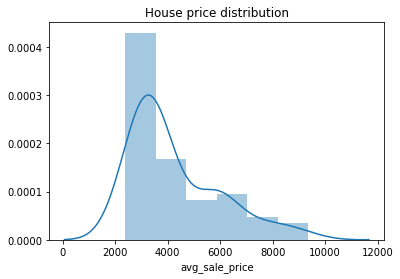

In [685]:
import seaborn as sns
sns.distplot(df1["avg_sale_price"],kde=True).set_title('House price distribution');

In [686]:
df1.describe()

,avg_sale_price
count,72.000000
mean,4243.680556
std,1704.649952
min,2372.000000
25%,3068.000000
50%,3542.500000
75%,5534.000000
max,9366.000000


df1.loc[ df1['avg_sale_price'] <= 4000, 'price_category'] = 1
df1.loc[(df1['avg_sale_price'] > 4000) & (df1['avg_sale_price'] <= 6000), 'price_category'] = 2
df1.loc[(df1['avg_sale_price'] > 6000), 'price_category'] = 3

df1.head()

In [687]:
df1.loc[ df1['avg_sale_price'] <= 4000, 'price_category'] = 1
df1.loc[(df1['avg_sale_price'] > 4000), 'price_category'] = 2

df1.head()

,neighborhood,avg_sale_price,price_category
0,Piazza Duomo,9366.0,2.0
1,Pagano Metro,7764.0,2.0
2,Ticinese,7117.0,2.0
3,San Vittore,7117.0,2.0
4,Guastalla,7898.0,2.0


sns.barplot(df1.price_category.value_counts(),[1,2,3],orient='h',palette='Blues_r').set_title('Neighborhood in each category')
plt.xlabel('Count')
plt.ylabel('Category');

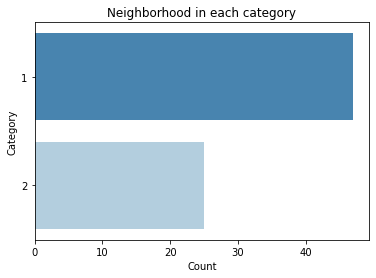

In [688]:
sns.barplot(df1.price_category.value_counts(),[1,2],orient='h',palette='Blues_r').set_title('Neighborhood in each category')
plt.xlabel('Count')
plt.ylabel('Category');

In [689]:
def get_x_y_milan(address1):
    lat_coords = 0
    lng_coords = 0
    g = geocode(address='{}, Milan,Italy,IT'.format(address1))[0]
    lng_coords = g['location']['x']
    lat_coords = g['location']['y']
    return lat_coords ,lng_coords

In [690]:
lat=[]
lng=[]
for i in range(0,df1.shape[0]):
    latit = get_x_y_milan(df1.neighborhood[i])[0]
    longit = get_x_y_milan(df1.neighborhood[i])[1]
    lat.append(latit)
    lng.append(longit)

In [691]:
df1['latitude'] = lat
df1['longitude'] = lng

In [692]:
df1.head()

,neighborhood,avg_sale_price,price_category,latitude,longitude
0,Piazza Duomo,9366.0,2.0,45.46468,9.19049
1,Pagano Metro,7764.0,2.0,45.46839,9.16043
2,Ticinese,7117.0,2.0,45.45394,9.18224
3,San Vittore,7117.0,2.0,45.46013,9.16633
4,Guastalla,7898.0,2.0,45.46113,9.19850


### Neighborhoods visualization on the Map

In [693]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

# First of all we need the Milan coordinates
milan_lat, milan_long = get_x_y_milan('Milan')

map_clusters = folium.Map(location=[milan_lat, milan_long], zoom_start=11)

kclusters = 3

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 0.5, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df1['latitude'], df1['longitude'], df1['neighborhood'], df1['price_category']):
    label = folium.Popup('Price Category ' + str(int(cluster)) + '\n' + str(poi) , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)]
        ).add_to(map_clusters)
        
map_clusters

In [694]:
# Foursquare API credentials
CLIENT_ID = 'FVJVMGB5ZRPXVF5MQQG3K0X0HJIIDUIK4OY4PBUMSRP5QCIE' # your Foursquare ID
CLIENT_SECRET = 'ZNJRC0B2JKYYSYLTLO4CPPOHQXO3SPSOJOKGDHUDTUMWSQLK' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: FVJVMGB5ZRPXVF5MQQG3K0X0HJIIDUIK4OY4PBUMSRP5QCIE
CLIENT_SECRET:ZNJRC0B2JKYYSYLTLO4CPPOHQXO3SPSOJOKGDHUDTUMWSQLK


In [695]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius
            )
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['neighborhood', 
                  'neighborhood latitude', 
                  'neighborhood longitude', 
                  'venue', 
                  'venue category']
    
    return(nearby_venues)

In [696]:
milan_venues = getNearbyVenues(df1['neighborhood'], df1['latitude'], df1['longitude'])

Piazza Duomo
Pagano Metro
Ticinese
San Vittore
Guastalla
Garibaldi Repubblica
Brera
De Angeli - Monte Rosa
Tre Torri
Portello
Navigli
Porta Romana
XXII Marzo
Buenos Aires - Venezia
Stazione Centrale
Lancetti
Giovanni Battista Bertini
Isola
Mac Mahon
Villapizzone
Maggiore - Musocco
Metro Rho Fieramilano
Bande Nere
Lorenteggio
Barona
Ronchetto sul Naviglio
San Cristoforo
Giambellino
Gratosoglio - Ticinello
Stadera
Tibaldi
Brenta
Calvairate
Adriano
Padova
Niguarda
Bicocca
Greco
Bruzzano
Tortona
Washington
Quarto Oggiaro
Bovisa
Dergano
Affori
Bovisasca
Comasina
Forze Armate
Selinunte
San Siro
Trenno
Gallaratese
QT 8
Quartiere degli Olmi
Baggio
Quarto Cagnino
Quinto Romano
Vigentina
Ex OM - Morivione
Ripamonti
Mecenate
Parco Monlué - Ponte Lambro
Città Studi
Corsica
Maciachini - Maggiolina
Viale Monza
Parco Lambro - Cimiano
Lambrate
Piazza Loreto
Triulzo Superiore
Rogoredo
Lodi - Corvetto


In [697]:
print(milan_venues.shape)
milan_venues.head()

(1430, 5)


,neighborhood,neighborhood latitude,neighborhood longitude,venue,venue category
0,Piazza Duomo,45.46468,9.19049,Piazza del Duomo,Plaza
1,Piazza Duomo,45.46468,9.19049,Galleria Vittorio Emanuele II,Monument / Landmark
2,Piazza Duomo,45.46468,9.19049,Terrazze del Duomo,Scenic Lookout
3,Piazza Duomo,45.46468,9.19049,Room Mate Giulia Hotel,Hotel
4,Piazza Duomo,45.46468,9.19049,Luini,Bakery


In [698]:
venues=pd.DataFrame(milan_venues['venue category'].value_counts())

In [699]:
venues.to_excel('venues.xlsx')

In [700]:
venues.head()

,venue category
Italian Restaurant,122
Pizza Place,96
Café,91
Hotel,60
Ice Cream Shop,56


In [701]:
milan_onehot = pd.get_dummies(milan_venues[['venue category']], prefix="", prefix_sep="")
milan_onehot

,Abruzzo Restaurant,Accessories Store,Adult Education Center,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,...,Tram Station,Trattoria/Osteria,Turkish Restaurant,Tuscan Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1425,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1426,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1427,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1428,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [702]:
# add neighborhood column back to dataframe
milan_onehot['neighborhood'] = milan_venues['neighborhood']
# move neighborhood column to the first column
fixed_columns = [milan_onehot.columns[-1]] + list(milan_onehot.columns[:-1])
milan_onehot = milan_onehot[fixed_columns]

milan_onehot.head()

,neighborhood,Abruzzo Restaurant,Accessories Store,Adult Education Center,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,...,Tram Station,Trattoria/Osteria,Turkish Restaurant,Tuscan Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,Piazza Duomo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Piazza Duomo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Piazza Duomo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Piazza Duomo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Piazza Duomo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [703]:
milan_grouped = milan_onehot.groupby('neighborhood').sum().reset_index()
milan_grouped

,neighborhood,Abruzzo Restaurant,Accessories Store,Adult Education Center,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,...,Tram Station,Trattoria/Osteria,Turkish Restaurant,Tuscan Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,Adriano,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Affori,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Baggio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bande Nere,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Barona,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,Viale Monza,0,0,0,0,0,0,0,0,0,...,3,1,0,0,0,0,0,0,0,0
68,Vigentina,1,0,0,0,0,0,0,0,0,...,3,0,0,0,0,0,0,0,0,0
69,Villapizzone,0,0,0,0,0,0,0,0,0,...,3,0,0,0,0,0,0,0,0,0
70,Washington,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [704]:
df1.set_index('neighborhood',inplace=True)

In [705]:
milan_grouped.to_excel('df1.xlsx')

In [706]:
df_joined = milan_grouped.join(df1,on='neighborhood')

In [707]:
df_joined.isna().sum()

neighborhood              0
Abruzzo Restaurant        0
Accessories Store         0
Adult Education Center    0
American Restaurant       0
                         ..
Yoga Studio               0
avg_sale_price            0
price_category            0
latitude                  0
longitude                 0
Length: 231, dtype: int64

In [708]:
df_joined.shape

(72, 231)

In [709]:
df_joined.tail()

,neighborhood,Abruzzo Restaurant,Accessories Store,Adult Education Center,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio,avg_sale_price,price_category,latitude,longitude
67,Viale Monza,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3422.0,1.0,45.514736,9.225304
68,Vigentina,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3930.0,1.0,45.433720,9.201040
69,Villapizzone,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3206.0,1.0,45.498340,9.144530
70,Washington,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,6202.0,2.0,45.460010,9.156950
71,XXII Marzo,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,6030.0,2.0,45.462690,9.211710


In [710]:
df_joined.drop('avg_sale_price',axis=1,inplace=True)

In [711]:
italian_restaurants = pd.DataFrame(np.sum(df_joined[['Italian Restaurant', 'Restaurant', 'Trattoria/Osteria', 
                                                     'Mediterranean Restaurant']],axis=1),columns=['Italian Restaurants'])
pizza_places=pd.DataFrame(df_joined['Pizza Place'])
coffee_and_snacks = pd.DataFrame(np.sum(df_joined[['Café', 'Bar', 'Sandwich Place', 'Bistro','Piadineria','Coffee Shop','Breakfast Spot', 
                                                   'Snack Place', 'Cafeteria', 'Juice Bar', 'Tea Room', 'College Cafeteria', 'Creperie',
                                                   'Salad Place', 'Buffet']],axis=1),columns=['Coffee and Snacks'])
hotels = pd.DataFrame(np.sum(df_joined[['Hotel', 'Bed & Breakfast', 'Hostel']],axis=1),columns=['Hotels'])
ice_cream_shops = pd.DataFrame(np.sum(df_joined[['Ice Cream Shop', 'Frozen Yogurt Shop']],axis=1),columns=['Ice Cream Shops'])
plazas = pd.DataFrame(np.sum(df_joined[['Plaza', 'Pedestrian Plaza']],axis=1),columns=['Plazas'])
markets_and_supermarkets = pd.DataFrame(np.sum(df_joined[['Supermarket', 'Convenience Store', 'Grocery Store', 'Food & Drink Shop', 
                                                          'Market', 'Cheese Shop', 'Farmers Market', 'Health Food Store', 'Discount Store', 
                                                          'Gourmet Shop', 'Chocolate Shop', 'Deli / Bodega', 'Butcher']],
                                               axis=1),columns=['Markets and Supermarkets'])
transports = pd.DataFrame(np.sum(df_joined[['Tram Station', 'Bus Stop', 'Bus Station', 'Train Station']],axis=1),columns=['Transports'])
japanese_and_sushi = pd.DataFrame(np.sum(df_joined[['Japanese Restaurant', 'Sushi Restaurant', 'Asian Restaurant', 'Ramen Restaurant', 
                                        'Noodle House']],axis=1),columns=['Japanese and Sushi'])
nightlife_bars = pd.DataFrame(np.sum(df_joined[['Cocktail Bar', 'Wine Bar', 'Brewery', 'Hotel Bar','Beer Garden', 'Lounge', 'Karaoke Bar', 
                                                'Dive Bar', 'Beer Bar', 'Speakeasy']],axis=1),columns=['Nightlife Bars'])
chinese_restaurants = pd.DataFrame(np.sum(df_joined[['Chinese Restaurant', 'Dim Sum Restaurant', 'Szechuan Restaurant']],
                                          axis=1),columns=['Chinese Restaurants'])
bakeries = pd.DataFrame(np.sum(df_joined[['Bakery', 'Dessert Shop', 'Cupcake Shop', 'Pastry Shop']],axis=1),columns=['Bakeries'])
parks = pd.DataFrame(np.sum(df_joined[['Park', 'Playground', 'Recreation Center', 'Skate Park', 'Garden Center', 
                                        'Theme Park Ride / Attraction', 'Beach']],axis=1),columns=['Parks'])
pubs_and_diner = pd.DataFrame(np.sum(df_joined[['Pub', 'Diner', 'Steakhouse', 'Gastropub', 'Irish Pub']],
                                     axis=1),columns=['Pubs and Diner'])
retail_stores = pd.DataFrame(np.sum(df_joined[['Clothing Store', 'Boutique', 'Shoe Store', 'Department Store', 'Furniture / Home Store', 
                                               'Pet Store', 'Cosmetics Shop', 'Gift Shop', 'Mobile Phone Shop', 'Sporting Goods Shop', 
                                               'Bike Shop', 'Shopping Plaza', 'Men\'s Store', 'Accessories Store', 'Thrift / Vintage Store', 
                                               'Kitchen Supply Store', 'Toy / Game Store', 'Candy Store', 'Flower Shop', 'Video Game Store', 
                                               'Board Shop', 'Hobby Shop', 'Smoke Shop']],axis=1),columns=['Retail Stores'])
books_and_music_stores = pd.DataFrame(np.sum(df_joined[['Bookstore', 'Record Shop', 'Music Store']],axis=1),columns=['Book and Music Stores'])
wellness = pd.DataFrame(np.sum(df_joined[['Gym / Fitness Center', 'Gym', 'Pool', 'Spa','Climbing Gym', 'Pool Hall', 
                                          'Yoga Studio']],axis=1),columns=['Wellness'])
seafood_restaurant =pd.DataFrame(df_joined['Seafood Restaurant'])
sport_clubs = pd.DataFrame(np.sum(df_joined[['Soccer Field', 'Athletics & Sports', 'Soccer Stadium', 'Tennis Court', 
                                             'Stadium', 'Tennis Stadium', 
                                             'Golf Course']],axis=1),columns=['Sport Clubs'])
art_places = pd.DataFrame(np.sum(df_joined[['Art Gallery', 'Performing Arts Venue', 'Art Museum', 'Music Venue', 'Science Museum', 
                                            'Theater', 'Comedy Club', 'Street Art', 'Public Art', 'Opera House', 'History Museum', 
                                            'College Arts Building', 'Jazz Club', 'Ballroom']],axis=1),columns=['Art Places'])
vegan_restaurant = pd.DataFrame(df_joined['Vegetarian / Vegan Restaurant'])
fast_foods = pd.DataFrame(np.sum(df_joined[['Fast Food Restaurant', 'Burger Joint', 'Food Court', 'Fried Chicken Joint', 
                                            'Food Truck']],axis=1),columns=['Fast Foods'])
pharmacies = pd.DataFrame(np.sum(df_joined[['Pharmacy', 'Medical Center']],axis=1),columns=['Pharmacies'])
nightclubs = pd.DataFrame(np.sum(df_joined[['Nightclub', 'Rock Club', 'Other Nightlife']],axis=1),columns=['Night Clubs'])
kebabs = pd.DataFrame(np.sum(df_joined[['Kebab Restaurant', 'Falafel Restaurant', 'Doner Restaurant']],axis=1),columns=['Kebabs'])
electronic_stores = pd.DataFrame(np.sum(df_joined[['Electronics Store', 'Hardware Store']],axis=1),columns=['Electronic Stores'])
monuments = pd.DataFrame(np.sum(df_joined[['Monument / Landmark', 'Church', 'Historic Site', 'Fountain', 
                                           'Outdoor Sculpture']],axis=1),columns=['Monuments'])
international_ethnic_restaurants = pd.DataFrame(np.sum(df_joined[['Indian Restaurant', 'Mexican Restaurant', 'Spanish Restaurant', 
                                                                      'Brazilian Restaurant', 'Moroccan Restaurant', 'Sri Lankan Restaurant',
                                                                      'Argentinian Restaurant', 'Roman Restaurant', 'German Restaurant', 
                                                                      'Tapas Restaurant', 'Turkish Restaurant', 'Vietnamese Restaurant', 
                                                                      'South American Restaurant', 'Filipino Restaurant', 'Greek Restaurant',
                                                                      'Peruvian Restaurant', 'Middle Eastern Restaurant', 'Thai Restaurant', 
                                                                      'American Restaurant', 'French Restaurant', 'Russian Restaurant', 
                                                                      'Lebanese Restaurant']],axis=1),columns=['International/Ethic Restaurants'])
cinemas = pd.DataFrame(np.sum(df_joined[['Multiplex', 'Movie Theater']],axis=1),columns=['Cinemas'])
malls = pd.DataFrame(np.sum(df_joined[['Shopping Mall', 'Outlet Store']],axis=1),columns=['Malls'])
wine_shops =pd.DataFrame(df_joined['Wine Shop'])
local_restaurants= pd.DataFrame(np.sum(df_joined[['Sicilian Restaurant', 'Puglia Restaurant', 'Abruzzo Restaurant', 
                                                  'Tuscan Restaurant', 'Sardinian Restaurant']],axis=1),columns=['Local Restaurants'])
studios = pd.DataFrame(np.sum(df_joined[['Design Studio', 'Photography Lab']],axis=1),columns=['Studios'])
offices_and_coworking = pd.DataFrame(np.sum(df_joined[['Coworking Space', 'Office', 
                                                       'Business Service']],axis=1),columns=['Offices and Coworking'])

In [712]:
df_final = pd.concat([italian_restaurants,pizza_places,coffee_and_snacks,hotels,ice_cream_shops,plazas,markets_and_supermarkets,
                      transports,japanese_and_sushi,nightlife_bars,chinese_restaurants,bakeries,parks,pubs_and_diner,retail_stores,
                      books_and_music_stores, wellness,seafood_restaurant,sport_clubs,art_places,vegan_restaurant,fast_foods,
                      pharmacies,nightclubs, kebabs,electronic_stores,monuments,international_ethnic_restaurants,cinemas,malls,
                      wine_shops,local_restaurants, studios,offices_and_coworking],axis=1)

In [713]:
df_final

,Italian Restaurants,Pizza Place,Coffee and Snacks,Hotels,Ice Cream Shops,Plazas,Markets and Supermarkets,Transports,Japanese and Sushi,Nightlife Bars,...,Kebabs,Electronic Stores,Monuments,International/Ethic Restaurants,Cinemas,Malls,Wine Shop,Local Restaurants,Studios,Offices and Coworking
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,3,2,2,0,0,2,0,0,1,...,1,0,0,0,0,0,0,0,0,0
2,1,0,3,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,3,2,3,3,2,1,1,1,2,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,2,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,4,1,2,1,2,1,1,3,0,1,...,0,0,0,0,0,0,0,1,0,1
68,1,1,3,0,1,1,2,3,0,0,...,0,0,0,1,0,0,0,1,0,0
69,5,1,2,4,1,3,1,3,0,1,...,0,1,0,1,0,0,0,0,0,0
70,5,2,3,1,1,1,3,0,2,1,...,0,1,0,0,0,0,0,0,0,0


In [714]:
df_final['neighborhood'] = df_joined['neighborhood']

In [715]:
metro = pd.read_excel('Metro.xlsx',index_col='Neighborhood')

In [751]:
metro.head()

,Metro Station
Neighborhood,
Piazza Duomo,1
Pagano Metro,1
Ticinese,1
San Vittore,1
Guastalla,1


In [717]:
df_final=df_final.join(metro,on='neighborhood')

In [718]:
df_final['Price Category'] = df_joined['price_category'].values

In [719]:
df_final.set_index('neighborhood',inplace=True)

In [720]:
df_final

,Italian Restaurants,Pizza Place,Coffee and Snacks,Hotels,Ice Cream Shops,Plazas,Markets and Supermarkets,Transports,Japanese and Sushi,Nightlife Bars,...,Monuments,International/Ethic Restaurants,Cinemas,Malls,Wine Shop,Local Restaurants,Studios,Offices and Coworking,Metro Station,Price Category
neighborhood,,,,,,,,,,,,,,,,,,,,,
Adriano,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
Affori,1,3,2,2,0,0,2,0,0,1,...,0,0,0,0,0,0,0,0,1,1.0
Baggio,1,0,3,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1.0
Bande Nere,3,2,3,3,2,1,1,1,2,0,...,0,0,0,0,0,0,0,0,1,1.0
Barona,1,0,2,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Viale Monza,4,1,2,1,2,1,1,3,0,1,...,0,0,0,0,0,1,0,1,1,1.0
Vigentina,1,1,3,0,1,1,2,3,0,0,...,0,1,0,0,0,1,0,0,0,1.0
Villapizzone,5,1,2,4,1,3,1,3,0,1,...,0,1,0,0,0,0,0,0,1,1.0


In [566]:
#X=df_joined.iloc[:,1:-4]

In [721]:
X=df_final.iloc[:,0:-1]

In [722]:
y=df_final.iloc[:,-1]

In [723]:
X_train, X_test, y_train, y_test = X[:-14], X[-14:], y[:-14], y[-14:]

## Grid search models

### Logistic Regresson

In [724]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=8, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.828869 using {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.723958 (0.151871) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.723958 (0.151871) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.695685 (0.138271) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.777530 (0.099020) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.777530 (0.099020) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.708333 (0.129456) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.811756 (0.123930) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.811756 (0.123930) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.765625 (0.154846) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.828869 (0.121869) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.828869 (0.121869) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.807292 (0.143227) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.762649 (0.136140) wit

### Ridge Classifier

In [727]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier

# define models and parameters
model = RidgeClassifier()
alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# define grid search
grid = dict(alpha=alpha)
cv = RepeatedStratifiedKFold(n_splits=8, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.758185 using {'alpha': 0.9}
0.695685 (0.139705) with: {'alpha': 0.1}
0.694940 (0.146159) with: {'alpha': 0.2}
0.700893 (0.137864) with: {'alpha': 0.3}
0.712054 (0.140542) with: {'alpha': 0.4}
0.712054 (0.140542) with: {'alpha': 0.5}
0.712054 (0.140542) with: {'alpha': 0.6}
0.729911 (0.142700) with: {'alpha': 0.7}
0.752232 (0.134948) with: {'alpha': 0.8}
0.758185 (0.129898) with: {'alpha': 0.9}
0.758185 (0.129898) with: {'alpha': 1.0}


### K-Nearest Neighbors (KNN)

In [730]:
# example of grid searching key hyperparametres for KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# define models and parameters
model = KNeighborsClassifier()
n_neighbors = range(1, 10, 1)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']

# define grid search
grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
cv = RepeatedStratifiedKFold(n_splits=8, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.816964 using {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
0.816964 (0.133556) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
0.816964 (0.133556) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}
0.689732 (0.126144) with: {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'uniform'}
0.811012 (0.134810) with: {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'}
0.730655 (0.153865) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
0.730655 (0.153865) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
0.730655 (0.142384) with: {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'uniform'}
0.736607 (0.138537) with: {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'distance'}
0.759673 (0.142483) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
0.759673 (0.142483) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
0.736607 (

### Support Vector Machine (SVM)

In [731]:
# example of grid searching key hyperparametres for SVC
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# define model and parameters
model = SVC()
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']

# define grid search
grid = dict(kernel=kernel,C=C,gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=8, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.851935 using {'C': 1.0, 'gamma': 'scale', 'kernel': 'poly'}
0.799107 (0.125027) with: {'C': 50, 'gamma': 'scale', 'kernel': 'poly'}
0.782738 (0.125495) with: {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
0.648810 (0.176676) with: {'C': 50, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.799107 (0.125027) with: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
0.782738 (0.125495) with: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.694940 (0.138792) with: {'C': 10, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.851935 (0.110016) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'poly'}
0.846726 (0.128037) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.715774 (0.121651) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.801339 (0.143998) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
0.674107 (0.054127) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.674107 (0.054127) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.674107 (0.054127) with: {'C': 0.01, 'gamma': 'scale'

### Bagged Decision Trees (Bagging)

In [732]:
# example of grid searching key hyperparameters for BaggingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier

# define models and parameters
model = BaggingClassifier()
n_estimators = [10, 100, 1000]

# define grid search
grid = dict(n_estimators=n_estimators)
cv = RepeatedStratifiedKFold(n_splits=8, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.789435 using {'n_estimators': 1000}
0.690476 (0.127178) with: {'n_estimators': 10}
0.784226 (0.131518) with: {'n_estimators': 100}
0.789435 (0.132530) with: {'n_estimators': 1000}


### Random Forest

In [733]:
# example of grid searching key hyperparameters for RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# define models and parameters
model = RandomForestClassifier()
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']

# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=8, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.846726 using {'max_features': 'sqrt', 'n_estimators': 100}
0.747768 (0.084439) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.846726 (0.122847) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.821429 (0.140607) with: {'max_features': 'sqrt', 'n_estimators': 1000}
0.748512 (0.111865) with: {'max_features': 'log2', 'n_estimators': 10}
0.813988 (0.128451) with: {'max_features': 'log2', 'n_estimators': 100}
0.809524 (0.138481) with: {'max_features': 'log2', 'n_estimators': 1000}


## Ensemble methods

In [735]:
# The following code creates and trains a voting classifier in Scikit-Learn, composed of three diverse classifiers

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(C=0.1,penalty='l2',solver='newton-cg')
rnd_clf = RandomForestClassifier(max_features='sqrt',n_estimators=100)
svm_clf = SVC(probability=True,C=1.0,gamma='scale',kernel='poly')
ridge_clf = RidgeClassifier(alpha=0.9)
knn_clf = KNeighborsClassifier(metric='euclidean',n_neighbors=2,weights='distance')
bagg_clf = BaggingClassifier(n_estimators=1000)


voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf), ('ridge',ridge_clf), ('knn',knn_clf),
                                         ('bagg',bagg_clf)], voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.1, solver='newton-cg')),
                             ('rf',
                              RandomForestClassifier(max_features='sqrt')),
                             ('svc', SVC(kernel='poly', probability=True)),
                             ('ridge', RidgeClassifier(alpha=0.9)),
                             ('knn',
                              KNeighborsClassifier(metric='euclidean',
                                                   n_neighbors=2,
                                                   weights='distance')),
                             ('bagg', BaggingClassifier(n_estimators=1000))])

In [738]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf,ridge_clf,knn_clf,bagg_clf,voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.7857142857142857
RandomForestClassifier 0.8571428571428571
SVC 0.7857142857142857
RidgeClassifier 0.6428571428571429
KNeighborsClassifier 0.7142857142857143
BaggingClassifier 0.7857142857142857
VotingClassifier 0.7857142857142857


In [739]:
rnd_clf.fit(X_train, y_train)
names=[]
scores=[]
for name, score in zip(X_train.columns, rnd_clf.feature_importances_):
    names.append(name)
    scores.append(score)

In [740]:
feat_import= pd.DataFrame(scores,names,columns=['Score'])

In [741]:
feat_import.sort_values('Score',ascending=False).head(20)

,Score
Nightlife Bars,0.095532
Bakeries,0.083484
Ice Cream Shops,0.080371
Italian Restaurants,0.073578
Japanese and Sushi,0.070658
Hotels,0.063640
Plazas,0.055516
Coffee and Snacks,0.038809
International/Ethic Restaurants,0.037851
Metro Station,0.033899


In [742]:
feat_import.reset_index(inplace=True)

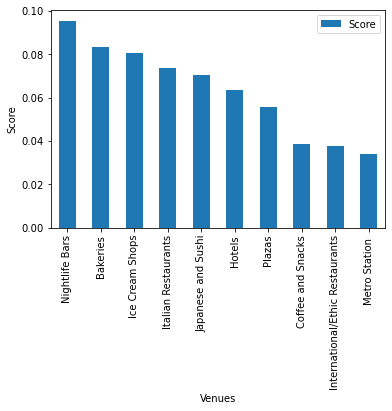

In [745]:
feat_import.sort_values('Score',ascending=False)[:10].plot.bar('index','Score')
plt.xlabel('Venues')
plt.ylabel('Score');

### Performance Measurement

In [746]:
y_pred = rnd_clf.predict(X_test)

In [762]:
from sklearn.metrics import precision_score,recall_score

precision_score(y_test ,y_pred)

1.0

In [763]:
recall_score(y_test,y_pred)

0.75

In [764]:
from sklearn.metrics import f1_score
f1_score(y_test,y_pred)

0.8571428571428571

In [765]:
prediction = rnd_clf.predict(X_test)

In [767]:
comparison_df = pd.DataFrame(y_test)

In [768]:
comparison_df['Prediction'] = prediction

In [769]:
comparison_df

,Price Category,Prediction
neighborhood,,
Selinunte,1.0,1.0
Stadera,1.0,1.0
Stazione Centrale,2.0,2.0
Tibaldi,1.0,2.0
Ticinese,2.0,2.0
Tortona,2.0,2.0
Tre Torri,2.0,2.0
Trenno,1.0,1.0
Triulzo Superiore,1.0,1.0


#### Accurancy through Cross Validation

In [756]:
from sklearn.model_selection import cross_val_score
cross_val_score(rnd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.85      , 0.78947368, 0.78947368])

We have an mean accurancy of approx. 80%

#### Confusion Matrix

In [760]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(rnd_clf,X_train,y_train,cv=3)

In [761]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train,y_train_pred)

array([[37,  2],
       [ 9, 10]], dtype=int64)